<center><h1>Zillow Predictions</h1></center>

# Importing Libraries

We will use the following libraries for this project:

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import time
import os

# Obtaining Data

We will begin by obtaining the data needed for this project using the Pandas Library to import the 'zillow_data.csv' file saved in this repository. 

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Scrubbing Data

Here we will scrub the data down to houston zip codes without any missing values.

In [4]:
# Defining list of dataframes for each state.
states = df['State'].unique()
state_df = []
for state in states:
    state_df.append(df[df['State']==state].copy())

# Defining dataframe for Houston zipcodes 
houston = state_df[1][state_df[1]['City'] == 'Houston'].copy()
houston.set_index(keys='RegionName',inplace=True)

# Creating dataframe of zipcodes by average price and viewing top three
houston_zips_by_mean = pd.DataFrame(houston.iloc[:, 6:-1].mean(axis=1), columns=['Mean'])
houston_zips = houston_zips_by_mean.index 
houston_zips_by_mean.sort_values(by='Mean').head(3) 

# Defining list of datatframes for each Houston zipcode
houston_zips_df = []
for i in houston_zips[:1]:
    z = houston[houston.index==i].drop(['RegionID', 'City', 'State', 
                                        'Metro', 'CountyName', 'SizeRank'],axis=1).melt().copy()
    z.index = pd.to_datetime(z.variable,format="%Y-%m")
    z.drop('variable',axis=1,inplace=True)
    
    # Checking for null values and removing them from the Houston Zip list
    if z.isna().sum().all()>0:
        houston_zips.remove(i)
        continue
    else:
        houston_zips_df.append(z)
        # Saving each zipcode as separate dataframe        
        outname = f'{i}.csv'
        outdir = './zipcodes'
        if not os.path.exists(outdir):
            os.mkdir(outdir)
        fullname = os.path.join(outdir, outname)    
        z.to_csv(fullname)

# Exploring Data

Here we will load the saved dataframes and added each one into a list. We will then visualize the data, looking for trends, seasonality, and residuals using Seasonal_Decomposition. We will also look at the ACF and PACF Curves. Since we have a large number of zipcodes, we will only display the graphs for one zipcode. EDA for all other zipcodes can be found in the `'Mod-4-EDA.ipynb'` file.

In [30]:
loaded_houston_dfs = []
for o in houston_zips[:1]:
    loaded_zip = pd.read_csv(f'{o}.csv')
    loaded_houston_dfs.append(loaded_zip)

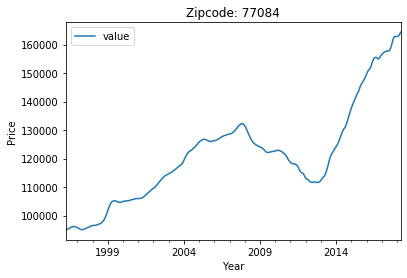

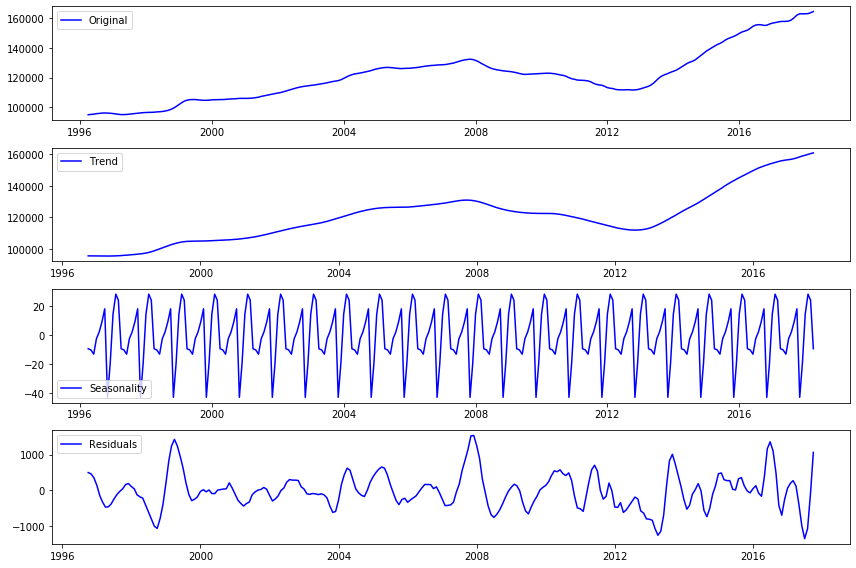

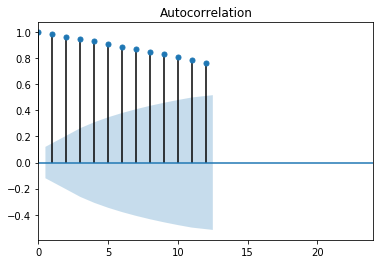

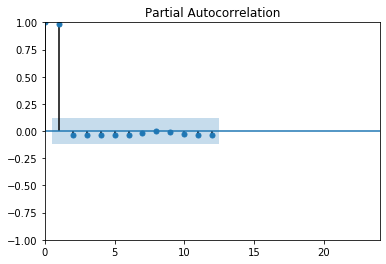

In [31]:
for z in loaded_houston_dfs[:1]:
    z.index = pd.to_datetime(z.variable,format="%Y-%m")
    z.drop('variable',axis=1,inplace=True)
    z.plot()
    plt.title('Zipcode: {}'.format(i))
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show();

    # Applying seasonal_decompose()
    decomposition = seasonal_decompose(z)
    
    # Gathering the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(z, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

    # Plotting ACF and PACF Curves
    plot_acf(z, lags=12); plt.xlim(0,24); plt.show()
    plot_pacf(z,lags=12); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

# Modeling Data

Here we can load the saved dataframes and added each one into a list. We will create a baseline model, generate forecasts on the test period, store forecasts and MSE for each zipcode. We will also view the average MSE.

Since we have a large number of zipcodes, we will only display the forecasts for one zipcode. Forecasts for all other zipcodes can be found in the `'Mod-4-Forecasts.ipynb'` file.

We will start by creating a baseline model for one zipcode. We will use a test period of the last twelve months.

In [32]:
test_period = 12
zip_dfs = []
models = []
start = time.time()

for e in houston_zips_df[:1]:
    ## month and day features
    e['Month'] = e.index.month
    e['Day'] = e.index.dayofyear
    e['Year'] = e.index.year - e.index.year.min()
    date_features = ['Month','Year']
    ## month and day polynomials
    polynomial_terms = [2,3]
    for feature in date_features:
        for i in polynomial_terms:
            e[feature+'**'+str(i)] = e[feature]**i
    ## previous values and polynomials
    previous_values_range = 36
    for i in range(1,previous_values_range):
        e['Previous'+str(i)] = e['value'].shift(i).bfill()
        for j in polynomial_terms:
            e['Previous'+str(i)+'**'+str(j)] = (e['value'].shift(i).bfill())**j
    ## fit model
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform((e.drop(['value'],axis=1)[:-test_period]))
    y = e['value'][:-test_period]
    reg = LassoLarsCV(cv=5).fit(X,y)
    zip_dfs.append(e)
    models.append(reg)
print('Time:', time.time()-start, 'seconds.')

Time: 0.7176198959350586 seconds.


Now that we have the baseline model: 
- generate forecasts on the test period, 
- store forecast dataframes, 
- save the MSE for each model, 
- and view average MSE across all zipcodes. 

In [33]:
forecast_dfs = []
start = time.time()
mses = []
for model, df_,z in zip(models, zip_dfs, houston_zips):
    actual = df_[-test_period:]['value']
    forecast = []
    ## create and populate forecast dataframe
    forecast_df = df_.copy()
    for datetime, date in zip(df_.index[-test_period:], range(len(df_)-test_period, len(df_))):
        values = []
        ## add datetime components
        values.append(datetime.month)
        values.append(datetime.dayofyear)
        values.append(datetime.year - (df_.index.year.min()))
        ## add polynomial terms of datetime components
        for feature in date_features:
            for i in polynomial_terms:
                values.append((forecast_df[feature][date])**i)
        ## add previous values and polynomial terms of previous values
        for i in range(1,previous_values_range):
            values.append(forecast_df['value'][date-i])
            for j in polynomial_terms:
                values.append((forecast_df['value'][date-i])**j)
        ## make prediction on current datetime
        X = scaler.transform(np.array(values).reshape(1,-1))
        forecast_ = model.predict(X)[0]
        forecast.append(forecast_)
        ## append prediction to start of values array
        values.insert(0, forecast_)
        ## set forecast row in dataframe
        forecast_df.loc[datetime] = values
    forecast_dfs.append(forecast)
    # Saving the forecast dataframes
    mses.append(np.abs(mean_squared_error(actual, forecast)))
print('Time:', time.time()-start, 'seconds.')
print('Average MSE:', np.average(mses))

Time: 0.29036998748779297 seconds.
Average MSE: 18970490.894618418


- Here we will plot predictions vs actual values for each zipcode, along with the MSE.

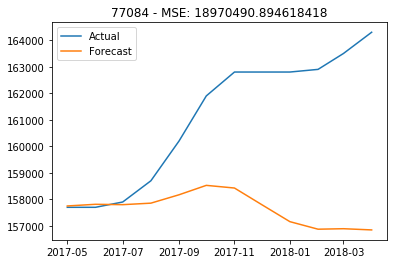

Time: 0.4666879177093506 seconds.


In [34]:
for df_, y_hat, mSe in zip(zip_dfs, forecast_dfs, mses):
    plt.plot(df_[-test_period:].index, df_[-test_period:]['value'])
    plt.plot(df_[-test_period:].index, y_hat)
    plt.legend(['Actual', 'Forecast'])
    plt.title(str(z)+' - MSE: '  + f'{mSe}')
    plt.show();
print('Time:', time.time()-start, 'seconds.')

## View features selected

- Below we can view the selected features for each zipcode's models.

In [35]:
for i,z in zip(models,houston_zips): 
    selected_features = pd.DataFrame()
    selected_features['Feature'] = zip_dfs[0].drop('value',axis=1).columns[i.coef_>0]
    selected_features['Coefficient'] = i.coef_[i.coef_>0]
    selected_features.sort_values('Coefficient')
    print(z)
    print(selected_features)
    print('--------------------------------')
print('Time:', time.time()-start, 'seconds.')

77084
          Feature   Coefficient
0           Month     36.538715
1        Month**3     67.859470
2         Year**3    325.992669
3       Previous1  30869.317991
4    Previous3**3   6533.913803
5    Previous6**2   1741.452970
6       Previous8    182.218367
7    Previous8**2   1405.685467
8   Previous13**3    835.970435
9      Previous19    762.423680
10  Previous19**3    200.164205
11  Previous23**3      5.108732
12  Previous24**3    330.187678
13     Previous25    672.896767
14  Previous25**3    715.604126
15  Previous28**3     52.901401
16  Previous29**3    493.950981
17     Previous34    578.987673
--------------------------------
Time: 0.4791109561920166 seconds.


## Predicting Future Prices and Fitting the Model to Entire Dataset

In [36]:
start = time.time()
todays = []
days = []
futures = []

# datetime = pd.to_datetime('2018-05-01',format="%Y-%m-%d")
for df_,zzz in zip(zip_dfs,houston_zips):
    print(f'Forecasting prices for zipcode : {zzz}')
    tomorrows = []
    date_times_ = []
    todays.append(df_['value'][-1])
    df___s = pd.DataFrame(columns=df_.columns)
    for datetime, date in zip(pd.Series([i + pd.offsets.BMonthBegin() for i in pd.date_range('2018-04-1', freq='3M', periods=11)]), 
                              range(len(df_.values[-1]),len(df_)+12)):
        nxt_month_date = len(df_)
        ## fit final model to entire dataset
        X = scaler.transform(df_.drop(['value'],axis=1))
        y = df_['value']       
        model = LassoLarsCV(cv=5).fit(X, y)
        values = []
        ## add datetime components
        values.append(datetime.month)
        values.append(datetime.dayofyear)
        values.append(datetime.year - (df_.index.year.min()))
        ## add polynomial terms of datetime components
        for feature in date_features:
            for i in polynomial_terms:
                values.append((df_[feature][date])**i)
        ## add previous values and polynomial terms of previous values
        for i in range(1,previous_values_range):
            values.append(df_['value'][date-i])
            for j in polynomial_terms:
                values.append((df_['value'][date-i])**j)
        ## make prediction on current datetime
        forecast = model.predict(np.array(values).reshape(1,-1))[0]
        new_vals = values.insert(0,forecast)
        date_times_.append(datetime)
        tomorrows.append(forecast)
        df__ = pd.DataFrame(np.array(values).reshape(1,-1),columns=df_.columns,index=[datetime])
        df___s = df___s.append(df__.loc[datetime])
        df_ = df_.append(df___s.loc[datetime],ignore_index=False)
        date_times_.append(datetime)
        tomorrows.append(forecast)
    days.append(date_times_)
    futures.append(tomorrows)
print('Time:', time.time()-start, 'seconds.')

Forecasting prices for zipcode : 77084
Time: 5.90245795249939 seconds.


## Importing All Predictions and Results

Here we can load the saved dataframes and view the results of our baseline models, the predicted forecasts. The results below are based on the predictions made in the 'Mod-4-Forecasts.ipynb' notebook.

In [37]:
predictions = pd.read_csv('Predictions.csv',index_col='Zip')
results = pd.read_csv('results',index_col='Zip')
results2 = pd.read_csv('results2',index_col='Zip')
results3 = pd.read_csv('results3',index_col='Zip')
results4 = pd.read_csv('results4',index_col='Zip')

In [38]:
print('Predictions Preview:')
display(predictions.head(1))

print('Current Price')
display(results.head(1))

print('By Long Term ROI: ')
display(predictions[predictions.columns[1:]].head(1))
display(results2.head(1))

print('By Mid Term ROI: ')
display(predictions[predictions.columns[1:-4]].head(1))
display(results3.head(1))

print('By Short Term ROI')
display(predictions[predictions.columns[1:-8]].head(1))
display(results4.head(1))

Predictions Preview:


,This Month,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01,ROI by 2019-02-01,ROI by 2019-05-01,ROI by 2019-08-01,ROI by 2019-11-01,ROI by 2020-02-03,ROI by 2020-05-01,ROI by 2020-08-03,ROI by 2020-11-02
Zip,,,,,,,,,,,,
77084,164300.0,-84551.619835,-84697.647766,-84860.606036,-85132.987297,-85109.759674,-85272.959507,-85132.42502,-85202.351409,-84798.242907,-84703.874175,-84407.127731


Current Price


,Current
Zip,
77084,164300.0


By Long Term ROI: 


,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01,ROI by 2019-02-01,ROI by 2019-05-01,ROI by 2019-08-01,ROI by 2019-11-01,ROI by 2020-02-03,ROI by 2020-05-01,ROI by 2020-08-03,ROI by 2020-11-02
Zip,,,,,,,,,,,
77084,-84551.619835,-84697.647766,-84860.606036,-85132.987297,-85109.759674,-85272.959507,-85132.42502,-85202.351409,-84798.242907,-84703.874175,-84407.127731


,LongTerm
Zip,
77084,-84897.236487


By Mid Term ROI: 


,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01,ROI by 2019-02-01,ROI by 2019-05-01,ROI by 2019-08-01,ROI by 2019-11-01
Zip,,,,,,,
77084,-84551.619835,-84697.647766,-84860.606036,-85132.987297,-85109.759674,-85272.959507,-85132.42502


,MidTerm
Zip,
77084,-84965.429305


By Short Term ROI


,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01
Zip,,,
77084,-84551.619835,-84697.647766,-84860.606036


,ShortTerm
Zip,
77084,-84703.291212


# Results

In [39]:
start = time.time() 
comb = pd.read_csv('Combined_Results.csv',index_col='Zip')

print('Combined Results Preview: ')
display(comb.head(3))

print('Top 5 Predictions Where to Buy for Short Term ROI:')
top_5_houston = comb.sort_values(by='ShortTerm', ascending=False).copy()
display(top_5_houston.head(5))

print('Top 5 Predictions Where to Buy for Mid Term ROI:')
top_5_houston2 = comb.sort_values(by='MidTerm', ascending=False).copy()
display(top_5_houston2.head(5))

print('Top 5 Predictions Where to Buy for Long Term ROI:')
top_5_houston3 = comb.sort_values(by='LongTerm', ascending=False).copy()
display(top_5_houston3.head(5))


print('Top 5 Cheapest Zips# Summary:')
top_5_houston4 = comb.sort_values(by=['Current'], ascending=True).copy()
display(top_5_houston4.head(5))


print('Time:', time.time()-start, 'seconds.')

Combined Results Preview: 


,Current,LongTerm,MidTerm,ShortTerm
Zip,,,,
77084,164300.0,-84897.236487,-84965.429305,-84703.291212
77036,189800.0,-110397.236487,-110465.429305,-110203.291212
77077,315900.0,-236497.236487,-236565.429305,-236303.291212


Top 5 Predictions Where to Buy for Short Term ROI:


,Current,LongTerm,MidTerm,ShortTerm
Zip,,,,
77028,81400.0,-1997.236487,-2065.429305,-1803.291212
77033,88400.0,-8997.236487,-9065.429305,-8803.291212
77029,91500.0,-12097.236487,-12165.429305,-11903.291212
77051,96900.0,-17497.236487,-17565.429305,-17303.291212
77078,99400.0,-19997.236487,-20065.429305,-19803.291212


Top 5 Predictions Where to Buy for Mid Term ROI:


,Current,LongTerm,MidTerm,ShortTerm
Zip,,,,
77028,81400.0,-1997.236487,-2065.429305,-1803.291212
77033,88400.0,-8997.236487,-9065.429305,-8803.291212
77029,91500.0,-12097.236487,-12165.429305,-11903.291212
77051,96900.0,-17497.236487,-17565.429305,-17303.291212
77078,99400.0,-19997.236487,-20065.429305,-19803.291212


Top 5 Predictions Where to Buy for Long Term ROI:


,Current,LongTerm,MidTerm,ShortTerm
Zip,,,,
77028,81400.0,-1997.236487,-2065.429305,-1803.291212
77033,88400.0,-8997.236487,-9065.429305,-8803.291212
77029,91500.0,-12097.236487,-12165.429305,-11903.291212
77051,96900.0,-17497.236487,-17565.429305,-17303.291212
77078,99400.0,-19997.236487,-20065.429305,-19803.291212


Top 5 Cheapest Zips# Summary:


,Current,LongTerm,MidTerm,ShortTerm
Zip,,,,
77028,81400.0,-1997.236487,-2065.429305,-1803.291212
77033,88400.0,-8997.236487,-9065.429305,-8803.291212
77029,91500.0,-12097.236487,-12165.429305,-11903.291212
77051,96900.0,-17497.236487,-17565.429305,-17303.291212
77078,99400.0,-19997.236487,-20065.429305,-19803.291212


Time: 0.04251813888549805 seconds.


# Visualizing Results

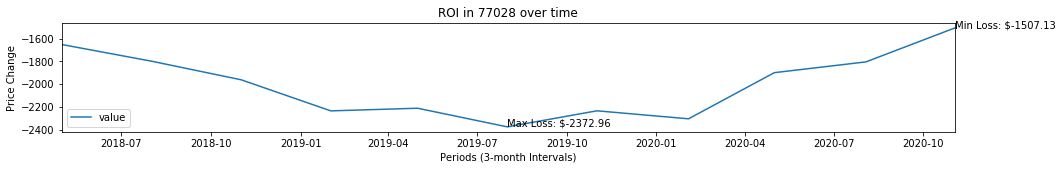

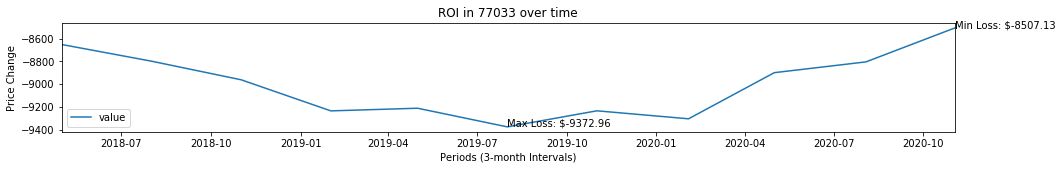

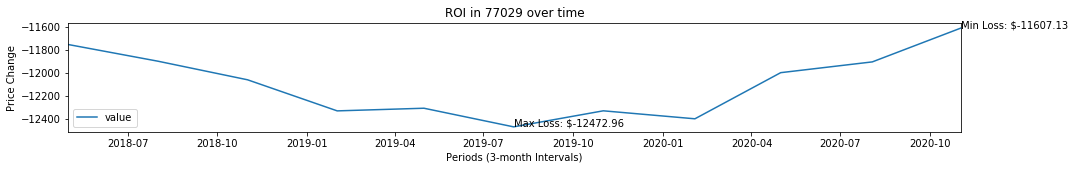

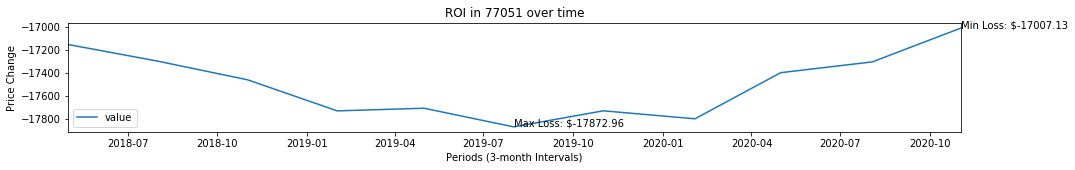

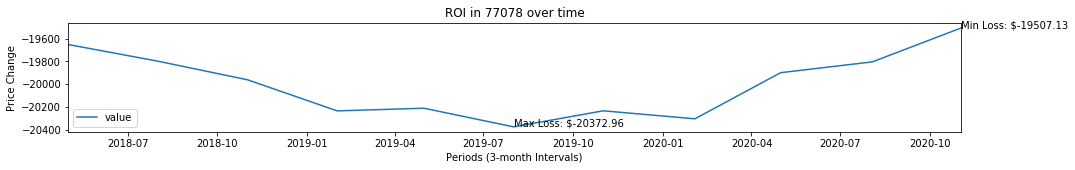

In [40]:
for i in list(top_5_houston.index[:5]):
    graph_zip = predictions[predictions.index == i].copy().melt()
    graph_zip.drop('variable',axis=1,inplace=True)
    graph_zip.drop([0],inplace=True)
    
    labels = list(predictions[predictions.index == i].copy().melt().drop([0]).variable)
    date_labels = [datetime.strptime(q[7:], '%Y-%m-%d').date() for q in labels]
    graph_zip.index = date_labels
     
    fig,ax = plt.subplots(nrows=1, ncols=1)
    x = list(graph_zip.index)
    y = list(graph_zip.value)
    ax.annotate('Max Loss: $'+str(round(min(y),2)),(x[5],min(y)))
    ax.annotate('Min Loss: $'+str(round(max(y),2)),(x[-1],max(y)))

    graph_zip.plot(figsize=(16, 2),ax=ax)
    plt.title(f'ROI in {i} over time')
    plt.ylabel('Price Change')
    plt.xlabel('Periods (3-month Intervals)')

    plt.show();
